# TDT4173 - Group 10: EDA and modelling history

`Group members`:
- Kaspar Paus Græsdal, 493880
- Oskar Holm, 527085
- Vegard Følstad Kolaas, 767941

In this notebook we ("gruppe 10" on Kaggle) will elaborate upon our exploratory data analysis, and the different models we have tried out pertaining to this year's (2022) project in TDT4173.

## The project

The aim of this project is to predict revenues of a set of Norwegian businesses in 2016. This is in other words a regression problem, with the target being the annual(?) revenue of the given business.

## The data sets

As is standard for a problem like this, we have been provided with a training and testing data set, but also a number of auxiliary csv files detailing extra features. The first two files are `stores_train.csv` and `stores_test.csv`, and the rest are
- `stores_extra.csv`: Another data file with all the same variables as `stores_train.csv` and `stores_test.csv`, but without revenue, possibly useful for unsupervised learning techniques.
- `plaace_hierarchy.csv`: A data set categorising businesses on multiple levels of specificity.
- `grunnkrets_norway_stripped.csv`: Data on Norwegian "basic statistical units"
- `grunnkrets_age_distribution.csv`: Data on measured age distributions in each basic statistical unit
- `grunnkrets_households_num_person.csv`: Data on the number of households in a statistical unit by category
- `grunnkrets_income_households.csv`: Data on the median income per household type in each basic statistical unit.
- `busstops_norway.csv`: Info on Norwegian bus stops. 


### The basic data set

The first three csv files consists of the following variables.

* `store_id`: The unique identifier of the store in question. Should have no meaningful relationship with revenue.
* `revenue`: Our target variable.
* `year`: The year in which the data was measured. All values should be 2016, and as such should also be uninportant for prediction.
* `store_name`, `address`, `sales_channel_name`, `mall_name` and `chain_name`: Human-readable names for addresses, general business type, and, if applicable, the name of the mall and chain of the business in question.
* `plaace_hierarchy_id`: A string identifying the business' corresponding row in `plaace_hierarchy.csv`.
* `grunnkrets_id`: A string denoting the row of the basic statistical unit to which the business belongs in `grunnkrets_stripped.csv`. 
* `lat`: The store's latitude
* `lon`: The store's longitude


# Part 1: Importing libraries and data

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Part 2: Explorotary Data Analysis (EDA)

## 2.1 ---en eller annen tittel som kan finnes igjen i kravene til EDA (ett av de fire som kreves)---

In [ ]:
# Reading the basic datasets
df_train = pd.read_csv('data/stores_train.csv')
df_test = pd.read_csv('data/stores_test.csv')
df_all = pd.concat([df_train, df_test])


print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['revenue'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 12859
Number of Test Examples = 8577

Training X Shape = (12859, 12)
Training y Shape = 12859

Test X Shape = (8577, 11)
Test y Shape = 8577

Train columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name', 'revenue']
Test columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name']


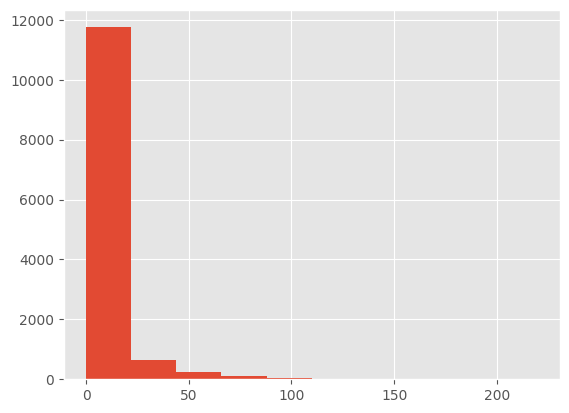

Standard quantiles: [  0.      1.195   3.374   7.996 219.599]
Mean: 8.220683101329808.


In [3]:
plt.hist(df_all["revenue"])
plt.show()

print(f'Standard quantiles: {np.quantile(df_train["revenue"], [0, 0.25, 0.5, 0.75, 1])}')
print(f'Mean: {np.mean(df_train["revenue"])}.')


## 2.2 ---passende tittel om det passer her---

The target distribution is extremely skewed. Depending on the modelling techniques we employ we may have to compenstate for this.

Identifying a cause for this skewness would also most likely be useful.

In [4]:
print(df_train.info())
df_train.sample(3)
df_train.describe([0, 0.25, 0.5, 0.75, 1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB
None


,year,grunnkrets_id,lat,lon,revenue
count,12859.0,1.285900e+04,12859.000000,12859.000000,12859.000000
mean,2016.0,9.338697e+06,61.212166,9.995425,8.220683
std,0.0,5.788875e+06,2.965672,3.793565,15.377130
min,2016.0,1.010105e+06,57.994443,4.625889,0.000000
0%,2016.0,1.010105e+06,57.994443,4.625889,0.000000
25%,2016.0,3.014208e+06,59.421935,7.284691,1.195000
50%,2016.0,9.065213e+06,59.939017,10.407916,3.374000
75%,2016.0,1.449011e+07,62.116531,10.848180,7.996000
100%,2016.0,2.030031e+07,71.098287,31.118935,219.599000
max,2016.0,2.030031e+07,71.098287,31.118935,219.599000


In [5]:
print(df_test.info())
df_test.sample(3)
df_test.describe([0, 0.25, 0.5, 0.75, 1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             8577 non-null   object 
 1   year                 8577 non-null   int64  
 2   store_name           8577 non-null   object 
 3   plaace_hierarchy_id  8577 non-null   object 
 4   sales_channel_name   8577 non-null   object 
 5   grunnkrets_id        8577 non-null   int64  
 6   address              7340 non-null   object 
 7   lat                  8577 non-null   float64
 8   lon                  8577 non-null   float64
 9   chain_name           2478 non-null   object 
 10  mall_name            1493 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 737.2+ KB
None


,year,grunnkrets_id,lat,lon
count,8577.0,8.577000e+03,8577.000000,8577.000000
mean,2016.0,9.319630e+06,61.245854,10.043396
std,0.0,5.853697e+06,2.988695,3.831924
min,2016.0,1.010103e+06,57.994183,4.627349
0%,2016.0,1.010103e+06,57.994183,4.627349
25%,2016.0,3.013801e+06,59.489149,7.354532
50%,2016.0,9.120105e+06,59.942074,10.418523
75%,2016.0,1.449030e+07,62.144366,10.924267
100%,2016.0,2.030031e+07,71.109922,31.102057
max,2016.0,2.030031e+07,71.109922,31.102057


## 2.3 Explore pairs and groups


NaNs (in the basic data sets) only occur in the columns "address", "chain_name" and "mall_name". Moreover, they occur in the test set as well as the training set, so unless we find some good way of handling them, we will likely lose performance.

Dropping the rows that contian them seems out of the question, as we only have ~1500 out of 12859 non-NaNs in 'mall_name'.

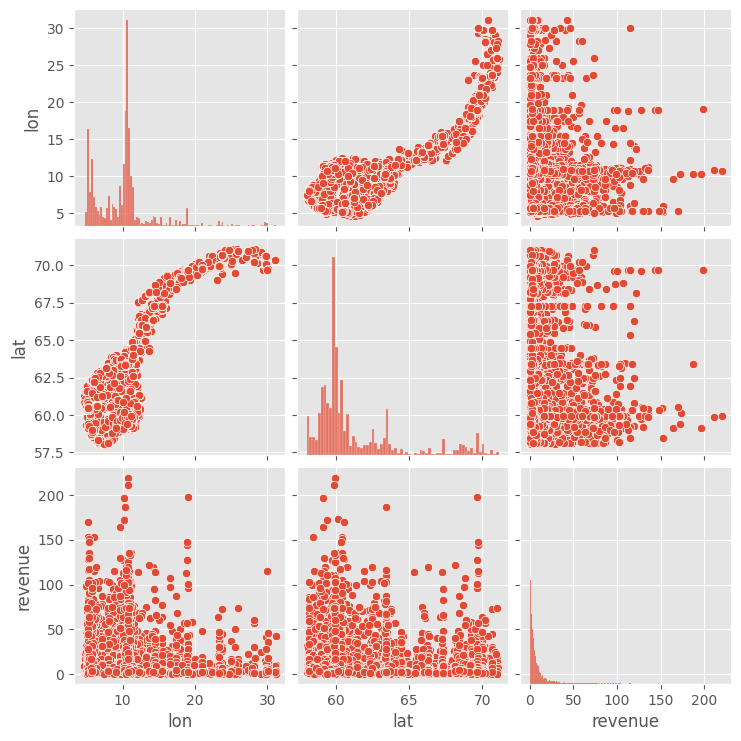

In [6]:
sns.pairplot(df_all, vars = ["lon", "lat", "revenue"])

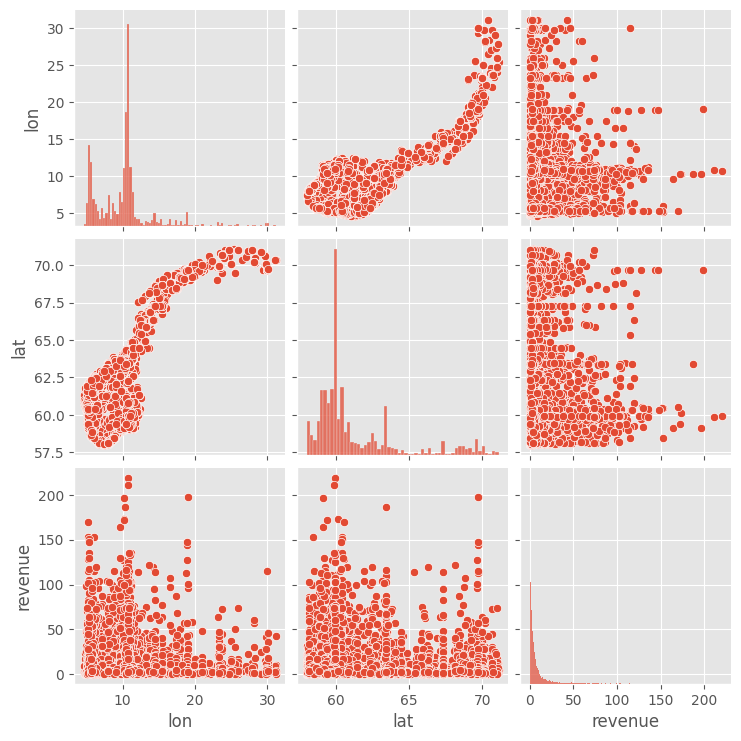

In [7]:
sns.pairplot(df_train, vars = ["lon", "lat", "revenue"])

From these pairplots we can make the following observations:

**EDA observation 1**

From looking at the logitude vs. latitude plots, as well as the latitude/longitude histograms, we see that although our data set contains businesses all over the country, their density across it is also quite skewed. In particular, there are large spikes around latitude 10 and longitude 60, and comparetively few stores far north and east. This applies for both the training and the test set.


**EDA observation 2**

There is clearly some type of relationship between revenue and longitude/latitude, though it is noisy, and might have some outliers. Once again we will need to inspect more closely to maybe gain more insight.

The two spikes noted under observation 2 also appear here. It might be worth trying to check whether this is because there are simply so many stores near these coordinates and some simply got lucky, if businesses there in fact tend to be more profitable, and/or if some of the variation is better explained by other variables.

#### Looking closer at `revenue`

Our pairs plot seemed to indicate our target variable was very unevenly distributed. We can check this using a box plot:

<AxesSubplot:>

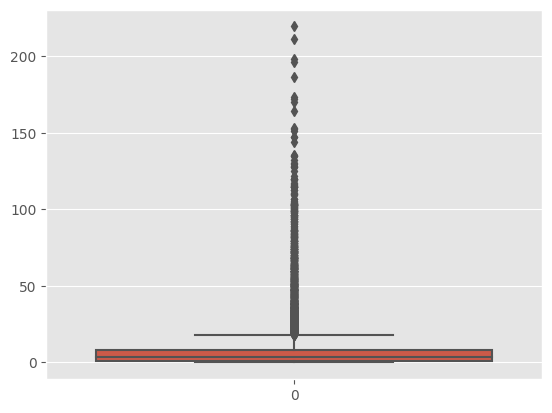

In [8]:
sns.boxplot(df_train['revenue'])

This confirms our suspicion. The overwhelming majority of data points are exactly, or very very close to 0. This makes prediction substantially harder. Transforming the target might help. We know from experience that a log transformation might be useful, as it naturally "stretches" out point distributions like this.

<AxesSubplot:xlabel='log_revenue', ylabel='Count'>

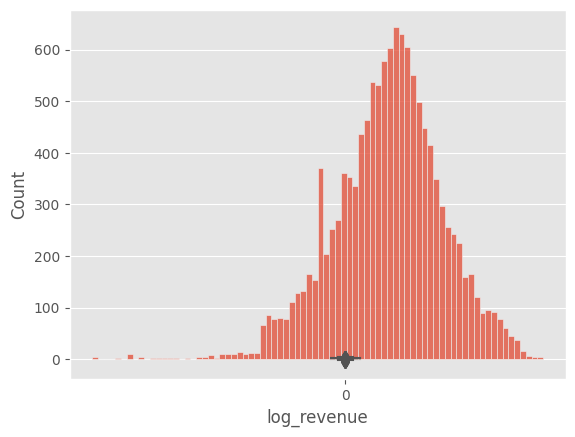

In [9]:
df_train["log_revenue"] = np.log(df_train["revenue"])
sns.boxplot(df_train["log_revenue"])
sns.histplot(df_train["log_revenue"])


<AxesSubplot:xlabel='root_revenue', ylabel='Count'>

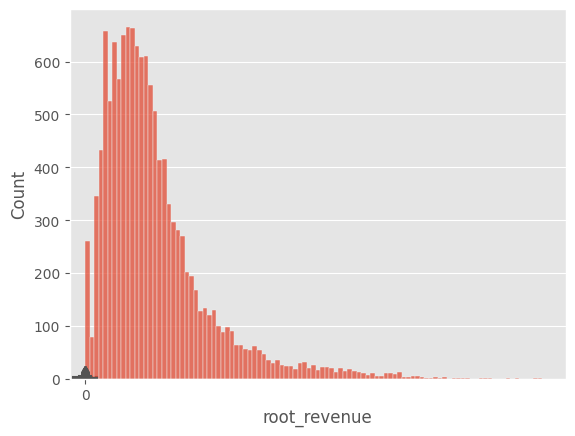

In [10]:
df_train["root_revenue"] = np.sqrt(df_train["revenue"])
sns.boxplot(df_train["root_revenue"])
sns.histplot(df_train["root_revenue"])

<AxesSubplot:xlabel='cube_root_revenue', ylabel='Count'>

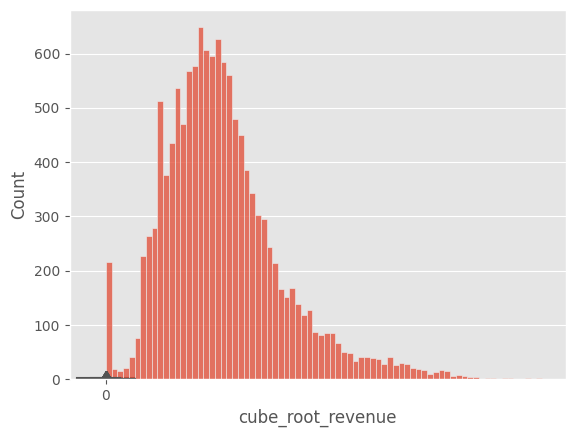

In [11]:
df_train["cube_root_revenue"] = np.cbrt(df_train["revenue"])
sns.boxplot(df_train["cube_root_revenue"])
sns.histplot(df_train["cube_root_revenue"])

This looks much better. Let's look at the pairs plot using this transformation.

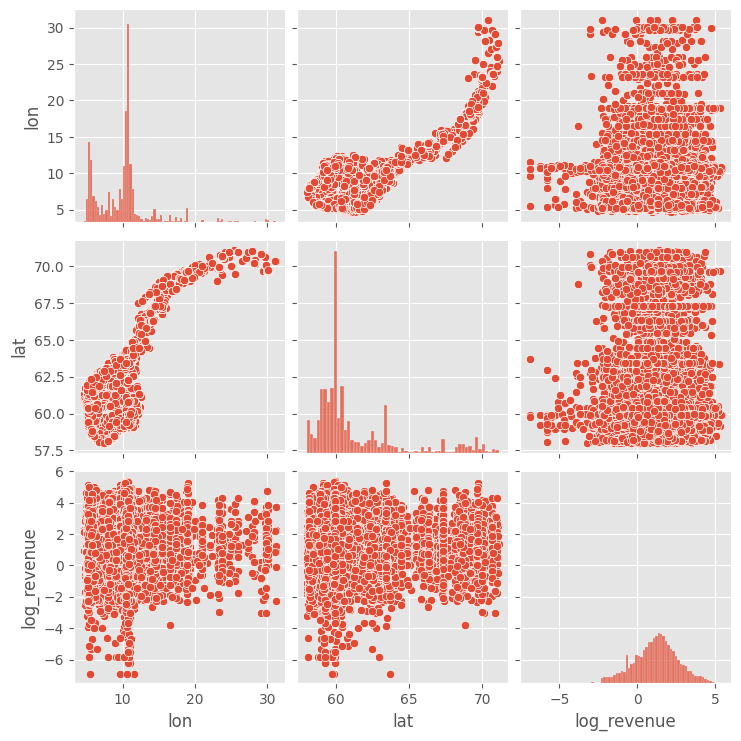

In [12]:
sns.pairplot(df_train, vars = ["lon", "lat", "log_revenue"])

The distribution of transformed revenue to other variables now looks much more closer to being normal, which should make model training more effective.

### Supplementary data

As stated previously we have also been provided with a number of supplementary data files. The first we will look at is `extra_stores.csv`...

**Note to self**:
Check whether grunnkrets ID is strictly increasing with latitude.

In [13]:
print(len(pd.read_csv('data/stores_extra.csv')))


28684


#### Exploring categorical variables

Our data has a lot of categorical variables, which can potentially cause difficulties during modelling. High dimentionality can be a particular culprit, so it might help to look at the data per se to formulate hypotheses about meaningful relationships.

Let's first consider the categorial variables present in the basic data sets.

In [14]:
df_all.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


We can immediately see that the data set contains a number of McDonald's and Burger King restaurants.

Counting the number of each is easy enough:

In [15]:
mc_D_rows = df_all[df_all['chain_name'].str.contains('MCDONALD', na = False)]
print(f"Number of McDonald's restaurants in data set:", len(mc_D_rows), ".")

BK_rows = df_all[df_all['chain_name'].str.contains('BURGER KING', na = False)]
print(f"Number of Burger King restaurants in data set:", len(BK_rows), ".")

Number of McDonald's restaurants in data set: 7 .
Number of Burger King restaurants in data set: 20 .


It turns out there are not that many of either.

It also seems that iteratively going through the basic data set like this will be way too much work, so let's look at the supplementary Plaace hierarchy data instead.

In [16]:
plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_all = df_all.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
df_all.head().T

,0,1,2,3,4
store_id,983540538-974187930-44774,987074191-973117734-44755,984890265-981157303-64491,914057442-992924179-126912,913018583-913063538-668469
year,2016,2016,2016,2016,2016
store_name,MCDONALD'S BRAGERNES TORG MAGASINET,MCDONALD'S KLINGENBERGGATA,BURGER KING HØNEFOSS,BURGER KING GLASSHUSPASSASJEN,BURGER KING TILLERTORGET
plaace_hierarchy_id,1.1.1.0,1.1.1.0,1.1.1.0,1.1.1.0,1.1.1.0
sales_channel_name_x,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants
grunnkrets_id,6020303,3010306,6050102,18040102,16017414
address,BRAGERNES TORG 13,NaN,KONG RINGS GATE 1,STORGATA 12,NaN
lat,59.743104,59.913759,60.164751,67.283669,63.358068
lon,10.204928,10.734031,10.254656,14.379796,10.374832
chain_name,MCDONALDS,MCDONALDS,BURGER KING,BURGER KING,BURGER KING


Using this, we can gain an intuition for what kind of businesses with which we are working by identifying all the unique descriptions for each hierarchy level.

**Observation**: At a glance it looks as though the `sales_channel_name` column might be redundant. All of it's values in the head subset match `lv4_desc_y`. This should be relatively easy to check while we're already inspecting Plaace hierarchy descriptions.

As a sanity check we print out the number of unique level 4 categories, as the introduction notebook said there should be 109 of them.

In [37]:
#Merge all the data
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
stores_with_grunnkrets = df_all.merge(spatial, how='left', on='grunnkrets_id')

stores_with_grunnkrets.head()
#sum(stores_with_grunnkrets["municipality_name"].isnull())

stores_with_grunnkrets = stores_with_grunnkrets.drop("address", axis = 1)
stores_with_grunnkrets = stores_with_grunnkrets.drop("mall_name", axis = 1)
stores_with_grunnkrets = stores_with_grunnkrets.drop("chain_name", axis = 1)
stores_with_grunnkrets[stores_with_grunnkrets.isna().any(axis=1)]
sum(stores_with_grunnkrets["grunnkrets_name"].isnull())

57

In [ ]:
lv1_descs = df_all['lv1_desc_y'].drop_duplicates()
lv1_descs = lv1_descs.T.drop_duplicates().T
print(f"Number of unique level one descriptions:", len(lv1_descs), ".")

lv2_descs = df_all['lv2_desc_y'].drop_duplicates()
lv2_descs = lv2_descs.T.drop_duplicates().T
print(f"Number of unique level 2 categories: ", len(lv2_descs), ".")

lv3_descs = df_all['lv3_desc_y'].drop_duplicates()
lv3_descs = lv3_descs.T.drop_duplicates().T
print(f"Number of unique level 3 categories: ", len(lv3_descs), ".")


lv4_descs = df_all['lv4_desc_y'].drop_duplicates()
lv4_descs = lv4_descs.T.drop_duplicates().T
print(f"Number of unique level 4 categories: ", len(lv4_descs), ".")


This seems off. The introduction notebook mentions 109 different level 4 categories.

Let's check whether the rest feature in the extra data set.

In [ ]:
print(max(df_all["revenue"]))

219.599


In [ ]:
df_extra = pd.read_csv("data/stores_extra.csv")
df_extra = df_extra.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
df_full = pd.concat([df_all, df_extra], ignore_index=True)

lv1_descs = df_full['lv1_desc_y'].drop_duplicates()
lv1_descs = lv1_descs.T.drop_duplicates().T
print(f"Number of unique level one descriptions:", len(lv1_descs), ".")

lv2_descs = df_full['lv2_desc_y'].drop_duplicates()
lv2_descs = lv2_descs.T.drop_duplicates().T
print(f"Number of unique level 2 categories: ", len(lv2_descs), ".")

lv3_descs = df_full['lv3_desc_y'].drop_duplicates()
lv3_descs = lv3_descs.T.drop_duplicates().T
print(f"Number of unique level 3 categories: ", len(lv3_descs), ".")


lv4_descs = df_full['lv4_desc_y'].drop_duplicates()
lv4_descs = lv4_descs.T.drop_duplicates().T
print(f"Number of unique level 4 categories: ", len(lv4_descs), ".")

#NOTE to self: Check if the error disappears when only concatenating the extra set with the training set.




### Encoding testing

We have a choice between several different encoders. Here we consider

## Models

Here we will elaborate upon the models we have tried.

### XGBoost

The first (and so far only) model we tried is XGBoost. This model is a type of ....